# 2D Heat Equation

Let us consider simulating the 2D Heat Equation
$$\frac{\partial U}{\partial t} = D \left(\frac{\partial^2 U}{\partial x^2} + \frac{\partial^2 U}{\partial y^2}\right).$$

It's finite approximation is written as
$$\frac{u^{n+1}_{i,j} - u^n_{i,j}}{\Delta t} = D\left(\frac{u^n_{i+1, j} - 2u^n_{i, j} + u^n_{i-1, j}}{(\Delta x)^2} + \frac{u^n_{i, j+1} - 2u^n_{i, j} + u^n_{i, j-1}}{(\Delta y)^2}\right).$$
Explicitly, the forward iteration scheme is
$$u^{n+1}_{i,j} = u^n_{i,j} + \Delta tD\left(\frac{u^n_{i+1, j} - 2u^n_{i, j} + u^n_{i-1, j}}{(\Delta x)^2} + \frac{u^n_{i, j+1} - 2u^n_{i, j} + u^n_{i, j-1}}{(\Delta y)^2}\right).$$

In [ ]:
import numpy as np
import cupy as xp

import matplotlib.pyplot as plt

import time

In [ ]:
# https://scipython.com/book/chapter-7-matplotlib/examples/the-two-dimensional-diffusion-equation/

# plate size, mm
w = h = 10
# intervals in x-, y- directions, mm
dx = dy = 0.01
# Thermal diffusivity of steel, mm2.s-1
D = 5

max_iter_time = 10_000

For technical reasons, the timestep depends on the thermal diffusivity and resolution size.

In [ ]:
def set_initial_conditions(u):
    u[:, :] = 0

    u[0, :] = 5
    u[-1, :] = 5
    u[:, 0] = 5
    u[:, -1] = 5

    d = 50
    u[nx//2 - d: nx//2 + d, ny//2 - d: ny//2 + d] = 5

    return u

In [ ]:
nx, ny = int(w / dx), int(h / dy)

dx2, dy2 = dx * dx, dy * dy
dt = dx2 * dy2 / (2 * D * (dx2 + dy2))

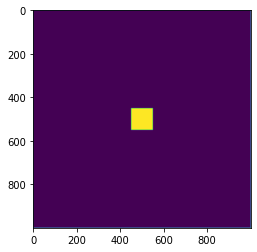

In [ ]:
u0 = np.zeros((nx, ny))
u0 = set_initial_conditions(u0)

plt.imshow(u0)

In [ ]:
# Preallocating memory
u_python = u0.copy()

In [ ]:
%%timeit
for i in range(1, nx-1):
    for j in range(1, ny-1):
        uxx = (u0[i+1,j] - 2*u0[i,j] + u0[i-1,j]) / dx2
        uyy = (u0[i,j+1] - 2*u0[i,j] + u0[i,j-1]) / dy2
        u_python[i,j] = u0[i,j] + dt * D * (uxx + uyy)

2.93 s ± 722 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Vectorization
If you have loops that are highly parrallel, avoid performing loops in Python. There are two main methods to avoid looping in Python: map and reduce. Map is used when you want to apply one function to every element in a list (e.g. squaring each element), while reduce is when you want to reduce the list into one number (e.g. sum of the list). By using map and reduce, you no longer perform the loop in Python, but much faster C-like code.

For Numpy Arrays, mapping comes in two forms (1) vectorization and (2) broadcasting. Broadcasting is a bit too involved to talk about here, but here are some examples of vectorization

In [ ]:
x = np.random.rand(100)
y = np.random.rand(100)

In [ ]:
# mapping the square to every element in x
out = x ** 2

In [ ]:
# mapping addition of two numbers to every element in x and y
out = x + y

Turns out, with a bit of effort, we can vectorize what we did above. This is the loop we want to vectorize

```
for i in range(1, nx-1):
    for j in range(1, ny-1):
        uxx = (u0[i+1,j] - 2*u0[i,j] + u0[i-1,j]) / dx2
        uyy = (u0[i,j+1] - 2*u0[i,j] + u0[i,j-1]) / dy2
        u_python[i,j] = u0[i,j] + dt * D * (uxx + uyy)
```

In [ ]:
# Preallocating memory
u_numpy = u0.copy()

In [ ]:
%%timeit
u_numpy[1:-1, 1:-1] = u0[1:-1, 1:-1] \
                      + dt * D * ((u0[2:, 1:-1] - 2 * u0[1:-1, 1:-1] + u0[:-2, 1:-1]) / dx2\
                                  + (u0[1:-1, 2:] - 2 * u0[1:-1, 1:-1] + u0[1:-1, :-2]) / dy2)

19 ms ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
np.testing.assert_almost_equal(u_numpy, u_python)

# Running the Simulation

In [ ]:
u = xp.zeros((nx, ny))
u = set_initial_conditions(u)

In [ ]:
simulated_time = 0

start = time.time()
results = [(simulated_time, u.copy())]
max_iter_time = 1_000
for k in range(max_iter_time):
    u[1:-1, 1:-1] = u[1:-1, 1:-1] \
                    + D * dt * ((u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1]) / dx2 \
                                + (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2]) / dy2)

    if (k + 1) % 500 == 0:
        print(f"{k + 1} finished")
        results.append((simulated_time, u.copy()))

    simulated_time += dt
end = time.time()

end - start

500 finished
1000 finished


3.4483747482299805

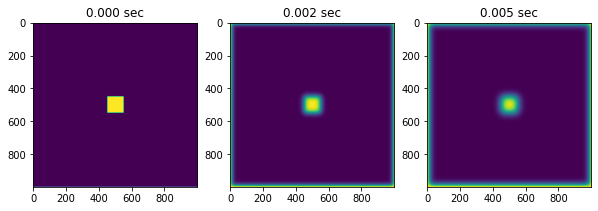

In [ ]:
plt.figure(figsize=(10, 5))
N = len(results)
for i, result in enumerate(results):
    t, u = result

    plt.subplot(1, N, i + 1)
    plt.imshow(u.get())
    plt.title(f"{t:.3f} sec")

Before you read onto the next section, I want you to swap
```
u = np.zeros((nx, ny))
u = set_initial_conditions(u)
```
into
```
u = xp.zeros((nx, ny))
u = set_initial_conditions(u)
```
If you recall, we imported `cupy as xp`. See if this made any change to the run time of the code.

# Cupy!

In [ ]:
u = xp.zeros((nx, ny))
u = set_initial_conditions(u)

In [ ]:
u.shape

(1000, 1000)

In [ ]:
simulated_time = 0

start = time.time()
results = [(simulated_time, u.copy())]
max_iter_time = 10_000
for k in range(max_iter_time):
    u[1:-1, 1:-1] = u[1:-1, 1:-1] \
                        + D * dt * ((u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1]) / dx2 \
                                    + (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2]) / dy2)

    if (k + 1) % 500 == 0:
        print(f"{k + 1} finished")
        results.append((simulated_time, u.copy()))

    simulated_time += dt
end = time.time()

end - start

500 finished
1000 finished
1500 finished
2000 finished
2500 finished
3000 finished
3500 finished
4000 finished
4500 finished
5000 finished
5500 finished
6000 finished
6500 finished
7000 finished
7500 finished
8000 finished
8500 finished
9000 finished
9500 finished
10000 finished


9.994120121002197

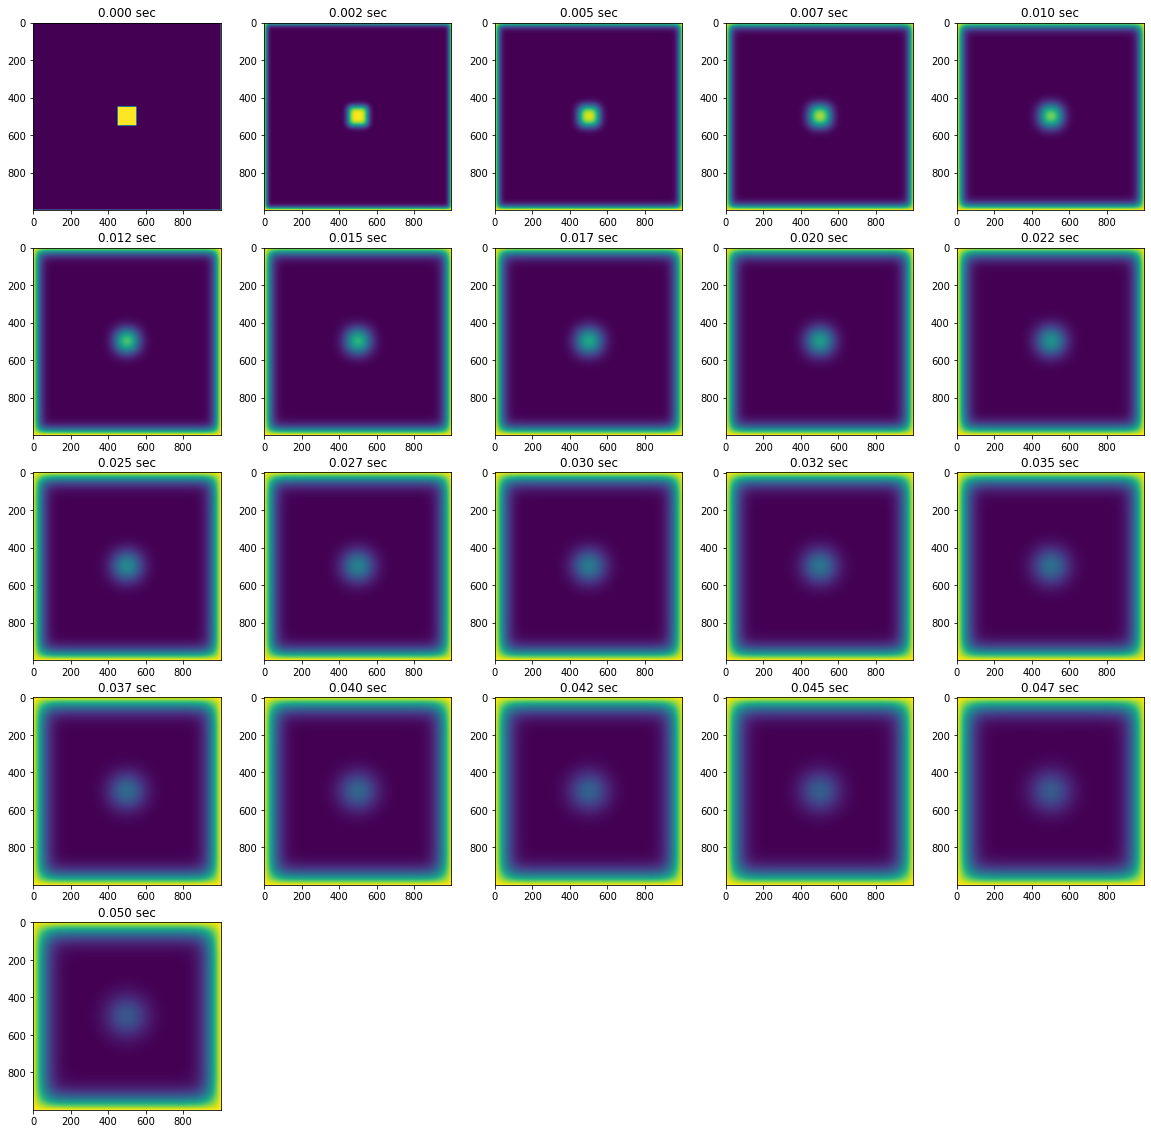

In [ ]:
plt.figure(figsize=(20, 20))
N = len(results)
for i, result in enumerate(results):
    t, u = result

    plt.subplot(N // 5 + 1, 5, i + 1)
    plt.imshow(u.get())
    plt.title(f"{t:.3f} sec")

# N-Body Simulation

Don't even try to ask me about this code, because I don't even understand. But see how the computation time changes when you use cupy vs numpy (change `import numpy as xp` to `import cupy as xp`, and make sure you re-define the functions) and when you increase/decreasing the number of bodies.

You should see that below ~100 particles, the CPU is faster than the GPU. But at 200+ GPU is much faster.

In [ ]:
import numpy as xp
import numpy as np

import matplotlib.pyplot as plt

import time

In [ ]:
def get_acceleration(pos, mass, G, softening):
	"""
    https://medium.com/swlh/create-your-own-n-body-simulation-with-python-f417234885e9

	Calculate the acceleration on each particle due to Newton's Law 
	pos  is an N x 3 matrix of positions
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	softening is the softening length
	a is N x 3 matrix of accelerations
	"""
	# positions r = [x, y, z] for all particles
	x = pos[:, 0:1]
	y = pos[:, 1:2]
	z = pos[:, 2:3]
	
	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y
	dz = z.T - z
	
	# matrix that stores 1/r^3 for all particle pairwise particle separations 
	inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2) ** (-1.5)
	
	ax = G * (dx * inv_r3) @ mass
	ay = G * (dy * inv_r3) @ mass
	az = G * (dz * inv_r3) @ mass
	
	# pack together the acceleration components
	a = xp.hstack((ax, ay, az))
	
	return a

def get_energy(pos, vel, mass, G):
	"""
	Get kinetic energy (KE) and potential energy (PE) of simulation
	pos is N x 3 matrix of positions
	vel is N x 3 matrix of velocities
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	KE is the kinetic energy of the system
	PE is the potential energy of the system
	"""
	# Kinetic Energy:
	KE = 0.5 * xp.sum(mass * vel**2)

	# Potential Energy:

	# positions r = [x,y,z] for all particles
	x = pos[:, 0:1]
	y = pos[:, 1:2]
	z = pos[:, 2:3]

	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y
	dz = z.T - z

	# matrix that stores 1/r for all particle pairwise particle separations 
	inv_r = xp.sqrt(dx**2 + dy**2 + dz**2)
	inv_r[inv_r > 0] = 1.0 / inv_r[inv_r > 0]

	# sum over upper triangle, to count each interaction only once
	PE = G * xp.sum(xp.triu(-(mass * mass.T) * inv_r, 1))
	
	return KE, PE;

In [ ]:
# Simulation parameters
N         = 200    # Number of particles
t         = 0      # current time of the simulation
t_end     = 10.0   # time at which simulation ends
dt        = 0.01   # timestep
softening = 0.1    # softening length
G         = 1.0    # Newton's Gravitational Constant

# Generate Initial Conditions
np.random.seed(17)

mass = 20.0 * xp.ones((N, 1)) / N  # total mass of particles is 20

positions  = xp.array(np.random.randn(N, 3)) * 2
velocity  = xp.array(np.random.randn(N, 3))

# Convert to Center-of-Mass frame
velocity -= xp.mean(mass * velocity, 0) / xp.mean(mass)

acceleration = get_acceleration(positions, mass, G, softening)

KE, PE = get_energy(positions, velocity, mass, G)

num_timesteps = int(xp.ceil(t_end / dt))

In [ ]:
position_history = xp.zeros((N, 3, num_timesteps + 1))
position_history[:, :, 0] = positions

KE_history = xp.zeros(num_timesteps + 1)
KE_history[0] = KE

PE_history = xp.zeros(num_timesteps + 1)
PE_history[0] = PE

t_all = xp.arange(num_timesteps + 1) * dt

In [ ]:
start = time.time()
for i in range(num_timesteps):
    # (1/2) kick
    velocity += acceleration * dt / 2.0
    
    # drift
    positions += velocity * dt
    
    # update accelerations
    acceleration = get_acceleration(positions, mass, G, softening)
    
    # (1/2) kick
    velocity += acceleration * dt / 2.0
    
    # update time
    t += dt
    
    # get energy of system
    KE, PE = get_energy(positions, velocity, mass, G)
    
    # save energies, positions for plotting trail
    position_history[:, :, i + 1] = positions
    KE_history[i + 1] = KE
    PE_history[i + 1] = PE
end = time.time()

end - start

3.878744125366211

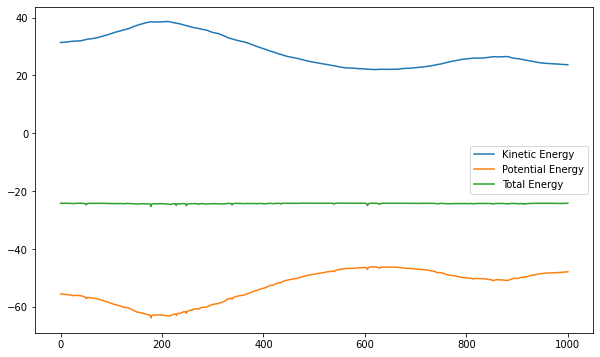

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(KE_history, label="Kinetic Energy")
plt.plot(PE_history, label="Potential Energy")
plt.plot(KE_history + PE_history, label="Total Energy")

plt.legend()

### Aside
A closed system preserves energy. However, your integration scheme may not, i.e., the system will lose or gain energy as you perform the numerical integration. But, there are integration schemes that explicitly preserve the energy which we see here. Even though the energy deviates far from the original total energy, it returns.

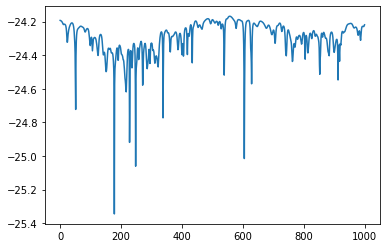

In [ ]:
plt.plot(KE_history + PE_history, label="Total Energy")

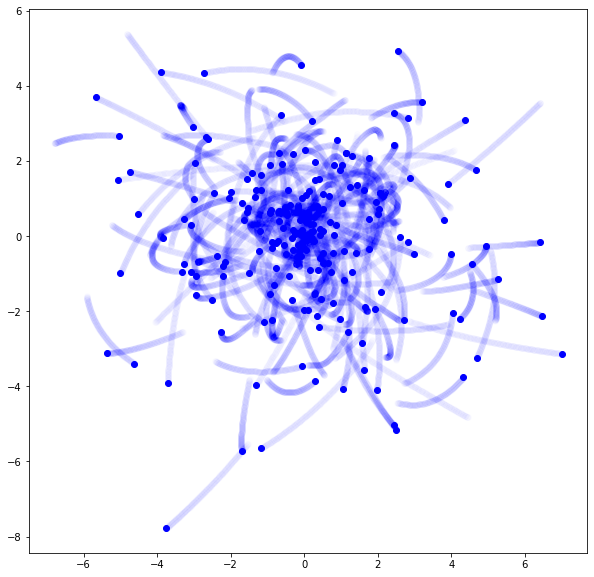

In [ ]:
plt.figure(figsize=(10, 10))
count = 0
for i in range(200):
    plt.scatter(position_history[:, 0, i], position_history[:, 1, i], color='blue', alpha=0.01)

plt.scatter(position_history[:, 0, 200], position_history[:, 1, 200], color='blue')

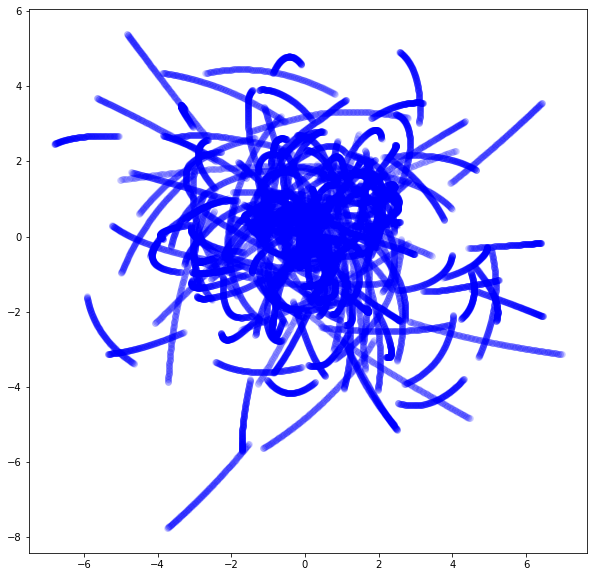

In [ ]:
plt.figure(figsize=(10, 10))
count = 0
for i in range(200):
    plt.scatter(pos_save[:, 0, i].get(), pos_save[:, 1, i].get(), color='blue', alpha=0.1)

plt.scatter(position_history[:, 0, 200].get(), position_history[:, 1, 200].get(), color='blue')

# Why Cupy as xp
Cupy is typically either imported as `xp` or `cp`. The choice of `cp` makes it explicitly clear that you are using Cupy rather than Numpy, while `xp` is more ambiguous for a reason. From the documentation:

*CuPy's interface is highly compatible with NumPy and SciPy; in most cases it can be used as a drop-in replacement. All you need to do is just replace numpy and scipy with cupy and cupyx.scipy in your Python code.*

As we've seen above, if we replace `import numpy as np` with `import cupy as np` our code works completely fine. As such, we can write code for computers both with and without a GPU.

In [ ]:
gpu_enabled = False
try:
    import cupy as xp
    gpu_enabled = True
except ModuleNotFoundError:
    import numpy as xp

import numpy as np  # We reserve np explicity for numpy

In [ ]:
gpu_enabled

True

We then use `xp` for any operations that we may want to be GPU accelerated, and keep `np` for any operations that we want on the CPU.